# Simple topology optimization for a bookshelf
## 1 Introduction
Let us consider a bookshelf that needs a support structure. To save material, the bookshelf should use only a fraction of a given design space, while being as stiff as possible to support many books.
The picture below shows the available two-dimensional design domain for such a bookshelf support. The left boundary $\partial \Omega_D$ is fixed to the wall and the top boundary $\partial \Omega_N$ is loaded with a uniform line load representing the weight of books.

<div>
    <center>
        <img src="img/domain.png" width="250"/>
    </center>
</div>

We could design drafts based on engineering intuition and may even simulate their performance. This way we could find the best out of multiple intuitive designs. However, this approach does not necessarily result in the best possible design. Instead, we want to apply topology optimization to find the optimal distribution of material in the design space. This approach is not based on engineering intuition, but a formal data-driven way to find a design suggestion for the bookshelf.

## 2 Formalizing the problem statement

First, the problem is described as a boundary value problem in the design domain $\Omega$ with the wall mount boundary $\partial \Omega_D$ and the load boundary $\partial \Omega_N$. Without considering the optimization yet, we can formulate the elastic problem as 

$$ \textrm{div}(\sigma) = 0 \quad \textrm{on} \quad \Omega $$

with the boundary conditions 

$$u = 0 \quad \textrm{on} \quad \partial\Omega_D $$

$$\sigma \cdot n = l \quad \textrm{on} \quad \partial\Omega_N. $$

We need to close this problem with a model that relates the stress $\sigma$ to the displacement $u$, such that the only remaining variables to solve are the horizontal displacement $u_1$ and vertical displacement $u_2$.

## 3 Material model 

A material model is required to compute the stress $\sigma$ for a given strain field, which is computed as the symmetric gradient of the displacement field via

$$\nabla^s u = \frac{1}{2} \left( \nabla u + \nabla u^\top\right).$$ 

A linear elastic material model is used to relate stress and strain via a stiffness tensor $\mathbb{C}$ as a linear map

$$ \sigma = \mathbb{C} : \nabla^s u$$

For an isotropic (i.e. it is orientation independend) linear material model, the stiffness tensor can be expressed in terms of the poisson ratio $\nu$ and elastic modulus $E$. The elastic modulus $E$ should depend on the presence of material in each location of the design domain. The stiffness should vanish, if there is no material and should be equal to the full stiffness of solid material $E_0$, when there is material. To model different material distributions, the field $\rho$ is introduced, which may be interpreted as the normalized density ranging from $0$ (there is no material) to 1 (there is solid material). Intermediate values may be interpreted as a hollow structure with voids. The stiffness at such intermediate values of $\rho$ is ambiguous and a model is required to describe this dependency. Here, the SIMP (Solid Isotropic Material with Penalization) approach is applied to compute 

$$ E = E_0 \rho^p .$$

The following Code section plots the SIMP relation for $p=1$, $p=2$ and $p=3$. 

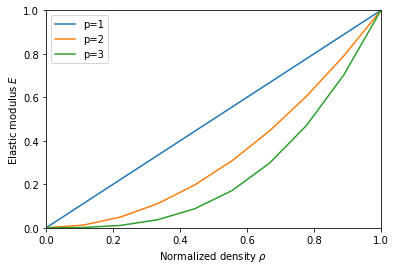

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Material parameters
p = 3
nu = 0.3
E0 = 1.0

# Plot the SIMP relation
rho_plot = np.linspace(0,1,10)
plt.plot(rho_plot, E0 * rho_plot**1.0, label="p=1")
plt.plot(rho_plot, E0 * rho_plot**2.0, label="p=2")
plt.plot(rho_plot, E0 * rho_plot**3.0, label="p=3")
plt.xlabel(r"Normalized density $\rho$")
plt.ylabel(r"Elastic modulus $E$")
plt.xlim([0, 1])
plt.ylim([0, E0])
plt.legend()
plt.show()


## 4 Finite element method
The Finite Element Method (FEM) is a numerical technique to solve the boundary value problem for a given field of material distribution $\rho$. It transforms the boundary value problem to a system of linear equations 

$$ K \vec{u} = B$$

which can be solved for the solution vector $\vec{u}$.

### 4.1 Mesh
The domain is subdived in many small elements. The parameter $r$ defines, how often the square domain should be subdivided into smaller elements and is therefore a measure, how fine the solution is.
The subdomain for the design space is defined such there is always one layer of elements at the load application region.

Note: you may need to restart the kernel to use updated packages.


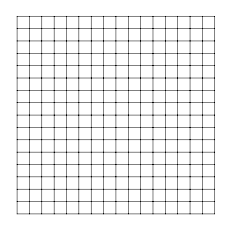

In [14]:
%pip install scikit-fem
import skfem as fem
from skfem.visuals.matplotlib import draw

# Mesh parameters
r = 4

# Mesh and element
mesh = fem.mesh.MeshQuad1().refined(r)
element = fem.ElementVector(fem.ElementQuad1())

# Tag top boundary and design subdomain
mesh = mesh.with_boundaries({"top": lambda x : x[1] == 1})
mesh = mesh.with_boundaries({"left": lambda x : x[0] == 0})
mesh = mesh.with_subdomains({"design": lambda x : x[1] <= 1.0-1.0/(2.0**r)})

# Draw the mesh
draw(mesh)

# Basis
basis = fem.Basis(mesh, element)
basis0 = basis.with_element(fem.ElementQuad0())
design_dofs = basis0.get_dofs(elements="design")

### 4.2 Boundary conditions
The top boundary is loaded with a uniform line load $l$ and the left boundary is a wall boundary.

In [15]:
# Select the boundary for load application
load_boundary = fem.FacetBasis(mesh, element, facets=mesh.boundaries["top"])
# Load at top
l = 1.0

# Select the wall boundary, the values default to 0
wall = basis.get_dofs({"left"})

### 4.3 Explicit expression of the isotropic material

Expressing the stiffness tensor for an isotropic material leads to

$$\sigma =  2 \mu \nabla^s u + \lambda \textrm{tr}(\nabla^s u) I,$$ 

with the Lame constants 

$$ \mu = \frac{E}{2(1+\nu)} $$ 

and

$$ \lambda = \frac{E\nu}{(1+\nu)(1-2\nu)}  .$$

### 4.4 Weak form of the momentum equation

> **_NOTE:_**  This is a bit technical. If you are not familiar with weak forms, you do not need to understand this and can skip this and go on with Section 5.

The weak form of the momentum balance is 

$$\underbrace{\int_\Omega \left(2 \mu \nabla^s u + \lambda \textrm{tr}(\nabla^s u) I \right)  : \nabla^s v dV}_{a(u,v)} = \underbrace{\int_{\partial \Omega_N} l v \cdot n dA}_{b(v)} \quad v \in H^1_0(\Omega)$$


In [16]:
from skfem.helpers import dot, ddot, sym_grad, trace, eye

# Helper definitions to compute Lame constants from elastic modulus
mu_prime =  1.0 / (2.0 * (1.0 + nu))
lbd_prime = nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

@fem.BilinearForm
def a(u, v, w):
    strain = sym_grad(u)
    stress = w.E * (2.0 * mu_prime * strain + lbd_prime * eye(trace(strain), 2))
    return ddot(stress, sym_grad(v))

@fem.LinearForm
def b(v, w):
    return l * dot(w.n, v)

## 5 Target function for topology optimization
The FEM discretization leads to a linear system of equations 

$$ K \vec{u} = B, $$

where $K$ is an $m \times m$  matrix and $B$ is an $m \times 1$ vector with the degrees of freedom $m$. The system is solved for $\vec{u}$, whenever this target function is called and the scalar strain energy 

$$ f = \frac{1}{2} \vec{u}^\top K \vec{u} $$

is returned. This strain energy is the energy stored inside the structure similar to an elastic spring (you may remember the formula $f = \frac{1}{2} ku^2$ for a spring with stiffness $k$). For a given load, the structure is considered stiff, if the strain energy is low.

In [17]:
def target_function(design):
    # Apply normalized densities
    rho = basis0.zeros() + 1.0
    rho[design_dofs] = design

    # Penalized material property field
    E = E0 * rho**p

    # Assembly
    K = fem.asm(a, basis, E=basis0.interpolate(E))
    B = fem.asm(b, load_boundary)

    # Solution
    u = fem.solve(*fem.condense(K, B, D=wall))
    
    # Evaluation of strain energy
    return 0.5 * (u @ K @ u)

## 6 Optimization
The optimization task is the minimization of the strain energy $f$ for a given maximum volume fraction $v$: 

$$ \textrm{mininimize} \quad f(\rho) $$
subject to
$$ \sum_{i=0}^N \hat{\rho}_i < v N $$
$$ 0.01 < \hat{\rho}_i < 1.0 $$

/Users/nilsmeyer/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Success state:True
Iterations: 45
Solver message: Optimization terminated successfully
Final strain energy: 1.9805491228763867


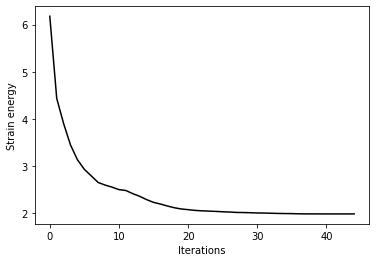

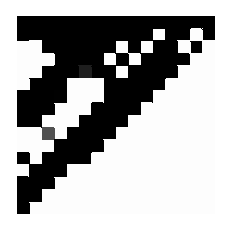

In [18]:
from skfem.visuals.matplotlib import plot
from scipy.optimize import minimize

# Volume constraint parameter
vol_constraint = 0.4

# Number of elements
N = len(basis0.get_dofs(elements="design").flatten())
# Initial guess is a homogeneous distribution 
rho0 = vol_constraint * np.ones(N)
# The design variables are limited to the range 0.01 to 1
bounds = N*[(0.01, 1.0)]
# The inequality constraint limits the maximum volume occupied by filled material
constraints = {'type':'ineq', 'fun': lambda x : vol_constraint*N-np.sum(x)}
# Save intermediate designs during optimization for plotting
designs = []
def callback(x, *args):
    designs.append(x)

# Run the actual optimization
res = minimize(
    target_function,
    rho0,
    constraints=constraints,
    bounds=bounds,
    callback=callback)
energies = [target_function(d) for d in designs]
print(f"Success state:{res.success}")
print(f"Iterations: {res.nit}")
print(f"Solver message: {res.message}")
print(f"Final strain energy: {energies[-1]}")

# Plot the optimization convergence
plt.plot(energies, "-k")
plt.xlabel("Iterations")
plt.ylabel("Strain energy")
plt.show()

# plot the resulting material distribution
rho = basis0.zeros() + 1.0
rho[design_dofs] = res.x
plot(mesh, rho, cmap=plt.cm.binary, vmin=0, vmax=1.0)
plt.show()

## 7 Tasks

### 7.1 Influence of parameters 
a) Modify the SIMP penalization parameter $p$ in Cell 1 and run the optimization again. What do you observe, if you set the parameter to $p=1$? 

b) Which parameter of $p$ makes it easy to intepret the result?

c) Modify the mesh refinements $r$ in Cell 2 (e.g. $r=3$ or $r=5$) and run the optimization again. How does it affect the computation time and the results?


d) Modify the volume fraction $v$ in Cell 6 (e.g. $v=0.2$ or $v=0.6$) and run the optimization again. Do the results agree with your engineering intuition?

### 7.2 Interpretation of result

a) You may observe some regions with a checkerboard pattern. Perform a short literature research to find the reason for such patterns and how to interpret them.

b) Pick parameters for $v$, $r$ and $p$ and use your favorie CAD program to draw a bookshelf model based on the optimization result.

### 7.3 Extensions of the model (advanced)
These tasks require you to modify the code and may require you to take a look at the documentation of [scikit-fem](https://scikit-fem.readthedocs.io/en/latest/). 

a) Extend the model to account for a gravitational load, such that the elastic equation becomes 

$$\textrm{div}(\sigma) = \rho g.$$



b) If the books are shorter than the bookshelf, the line load is not uniform but shifted to the left. Modify the code to account for a line load of the form 

$$l(x_1) = 20(1-x_1) \quad x_1 \in [0,1].$$